## Zero-Shot Audio Classification

Audio classification has many applications. For example, you may want to identify the language someone is speaking, or perhaps you want to know what birds are in your area. 

Let's build soud classifier. 

In the traditional classification, a model predicts a label from a predefined set of classes it was trained on. If there are no models trained on your specific set of classes, you would have to collect a dataset and fine-tune a model. 

Here, you'll use an alternative approach that doesn't require fine-tuneing. 

In [2]:
from datasets import load_dataset

dataset = load_dataset("ashraq/esc50",
                      split = "train[:10]")

Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 100%|██████| 2000/2000 [00:01<00:00, 1682.30 examples/s]


The **esc50** dataset is a labeled collection of five-second enviornmental sounds, such as sounds made by animals and humans, nature sounds, indoor sounds, urban noises. 

You are not going to need the whole dataset, so we're just going to load a few examples.

In [3]:
audio_sample = dataset[0]

In [4]:
audio_sample

{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 44100}}

Gonna take a listen at the sound of a cute dog barking.

In [5]:
from IPython.display import Audio as IPythonAudio

IPythonAudio(audio_sample["audio"]["array"],
             rate = audio_sample["audio"]["sampling_rate"])

Sounds like a dog to me.

Let's build the classification pipline.

In [6]:
from transformers import pipeline

zero_shot_classification = pipeline(
    task = "zero-shot-audio-classification",
    model = "laion/clap-htsat-unfused"
)

Device set to use mps:0


For this kind of audio classification you will need a pre-trained clap model.

At the moment it is one-of-a-kind architecture available for these tasks, So you can find it on the Hugging Face Hub by flitering models with feature extraction in the multi-model task and then flitering by the name clap. 

To classify your audio example, you'll only need to array of audio data.

However, the example has to have a sampling rate that the model expects. Let's step back and talk about the sampling rate. 

### Audio data

A sound wave is a continuous signal. This means it contains an infinite number of signal values in a given time. But the audio your computer cann work with is a series of discrete values, known as digital representation. 

To get the digital representation of a continuous audio signal, we first capture the sound with a microphone. Then the analog signal is converted into an electrical signal. Then the electrical signal is sampled to get the digital representation. 

![](https://lucid.app/publicSegments/view/943063fd-6d2a-45f6-a19d-d5f61994df0e/image.png)

### Sampling rate

**Sampling** = measuring the value of a continuous signal at fiexd time steps.

**Samling rate (Hz)** = the number of samples taken in one second.

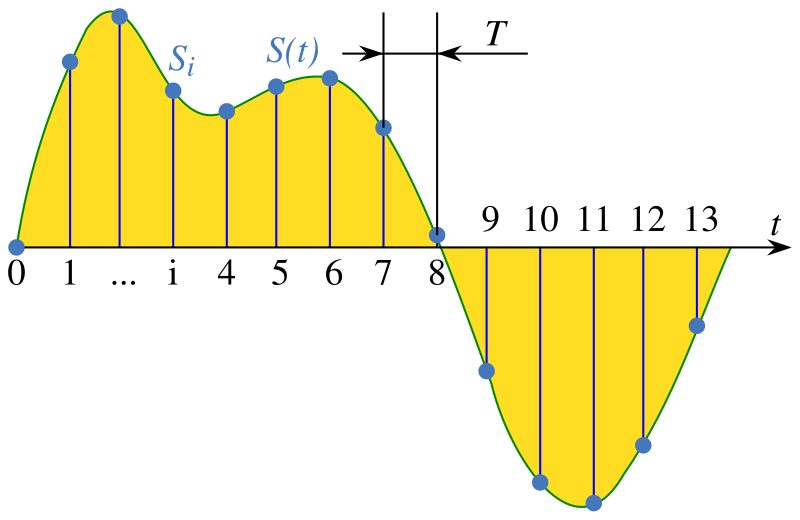

### Sampling rate examples

- **8,000 Hz**: telephone/walkie-talkie
- **16,000 Hz**: human speech recording
- **192,000 Hz**: high-resolution audio

---
**ZH**

🎧 采样率（Sampling Rate）示例说明：

采样率表示每秒钟对声音信号采样的次数，单位是“赫兹（Hz）”。采样率越高，音质越好，但文件也越大。

📞 8,000 Hz（8kHz）
	•	代表：电话、对讲机的音频质量
	•	特点：只保留了人声的基础频率，音质较低，但便于压缩和传输
	•	应用场景：电话语音、老式语音通信系统

🎙 16,000 Hz（16kHz）
	•	代表：一般人类语音录音
	•	特点：能更清晰地捕捉人类语音的细节，适用于语音识别、聊天机器人等
	•	应用场景：语音助手、语音识别、播客等

🎼 192,000 Hz（192kHz）
	•	代表：高分辨率音频（Hi-Res Audio）
	•	特点：远超人耳可听范围，用于追求极致音质的专业场景
	•	应用场景：高保真音乐制作、音响发烧友设备


📌 一般做语音识别，使用的是 16kHz；
📌 如果你是处理音乐、需要高音质，才会用到 44.1kHz、96kHz 或更高。

### Sampling rate for transformer models

**5-second sound**

- At 8,000 Hz => 5*8000 = 40,000 signal values
- At 16,000 Hz => 5*16,000 = 80,000 signal values
- At 192,000 Hz => 5*192,000 = 960,000 signal values

For a transformer trained on 16 kHz audio, an array of 960,000 values will look like a 60-second recording at 16kHz (60*16,000 = 960,000).

Let's take a one-second sound, which has been record with 192,000 Hz sampling rate.

In [8]:
# How many values will the array representing that sound have?

1 * 192000

192000

But if we take a model that has been trained on audio examples with 16,000 Hz sampling rate is it going to see as one second or more?

The model is going to see 192,000 values and it expects that one second contains 16,000 values. 

In [9]:
192000 / 16000

12.0

 So for this model, the recording is going to look like 12 seconds.

In [10]:
5 * 192000

960000

In [12]:
960000 / 16000

60.0

In [13]:
zero_shot_classification.feature_extractor.sampling_rate

48000

This model is recorded at 48,000 Hz. 

Let's check the sampling rate of our exampel.

In [14]:
audio_sample["audio"]["sampling_rate"]

44100

In this case, this is not a large difference in the sampling rate, and the model will likely do okay. But this is not always going to be the case, as you'll see in other examples. 

So, let's see how you can automatically cast the whole dataset to correct smapling rate when loading it with Datasets library.

In [16]:
from datasets import Audio

dataset = dataset.cast_column(
    "audio",
    Audio(sampling_rate= 48_000)
)

In [17]:
audio_sample = dataset[0]

In [18]:
audio_sample

{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000}}

In [19]:
candidate_labels = ["Sound of a dog",
                    "Sound of vacuum cleaner"]

In [20]:
zero_shot_classification(audio_sample["audio"]["array"],
                         candidate_labels = candidate_labels)

[{'score': 0.9985589385032654, 'label': 'Sound of a dog'},
 {'score': 0.0014411088777706027, 'label': 'Sound of vacuum cleaner'}]

Now, try more than two candidate labels. And then try some completely unrelated labels. 

In [22]:
candidate_labels = [
    "Sound of a child crying",
    "Sound of vacuum clearner",
    "Sound of a bird singing",
    "Sound of an airplane"
]

In [23]:
zero_shot_classification(audio_sample["audio"]["array"],
                        candidate_labels = candidate_labels)

[{'score': 0.6041479706764221, 'label': 'Sound of a bird singing'},
 {'score': 0.2326706349849701, 'label': 'Sound of vacuum clearner'},
 {'score': 0.12280820310115814, 'label': 'Sound of an airplane'},
 {'score': 0.04037324711680412, 'label': 'Sound of a child crying'}]